In [0]:
import numpy as np
import warnings
import os
from torch.utils.data import Dataset
warnings.filterwarnings('ignore')

import torch
import logging
# from tqdm import tqdm
from tqdm.notebook import tqdm
from random import randint, random
import sys
import importlib

import torch.nn.parallel
import torch.utils.data
from torch.autograd import Variable

import torch.nn.functional as F
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.gridspec as gridspec
from mpl_toolkits.mplot3d import Axes3D
training = True

In [0]:
USE_CUDA = torch.cuda.is_available()
print(USE_CUDA)
DEVICE=torch.device('cuda:0') # or set to 'cpu'

True


## Function for Map Definition

In [0]:
def occupancyGrid(map_width, map_height, width_start, height_start, grid_size):
  width_num = int(map_width/grid_size)
  height_num = int(map_height/grid_size)
  occgrid = np.zeros((height_num, width_num))
  grid_width = np.linspace(width_start, map_width+width_start, num = width_num+1)
  grid_height = np.linspace(height_start, map_height+height_start, num = height_num+1)
  return occgrid, grid_width, grid_height

#obs: 4*N array - left_bottom x/y, right_upper x/y (N rows - N obstacles)
def obstacleToGrid(obs, occgrid, grid_width, grid_height):
  grid_res = occgrid.copy()
  for i in range(obs.shape[0]):
    l= obs[i,:2]
    r = obs[i,2:]
    posl = l
    posr = r
    for j in range(len(grid_height)-1):
      if l[0] >= grid_height[j] and l[0] <= grid_height[j+1]:
        posl[0] = j
        break
    for j in range(len(grid_height)-1):
      if r[0] >= grid_height[j] and r[0] <= grid_height[j+1]:
        posr[0] = j
        break
    for j in range(len(grid_width)-1): 
      if l[1] >= grid_width[j] and l[1] <= grid_width[j+1]:
        posl[1] = j
        break
    for j in range(len(grid_width)-1): 
      if r[1] >= grid_width[j] and r[1] <= grid_width[j+1]:
        posr[1] = j
        break
    posl = posl.astype(int)
    posr = posr.astype(int)
    for m in range(posl[0], posr[0]+1):
      for n in range(posl[1], posr[1]+1):
        grid_res[m,n] = 1
  return grid_res

In [0]:
#for testing functions above
map_width = 60
map_height = 35
grid_size = 2.5
occgrid, grid_width, grid_height = occupancyGrid(map_width,map_height,-30,0,grid_size)
obs = np.array([[0.01,-29.99,6.99,-2.01],[0.01,2.01,6.99,29.99],[17.99,-19.99,19.99,-9.99],
               [22.99,4.99,27.99,9.99],[11.99,14.99,14.99,24.99]])
occgrid = obstacleToGrid(obs,occgrid,grid_width,grid_height)
# print(occgrid)

## Load Data

In [0]:
# sample points / initals / finals
data0308 = np.load("data0308.npz") # 31350, obstacle (-10,10)
data0416s = np.load("data0416_SIDE.npz") # 2055, obstacle (-5,5)
data0416b = np.load("data0416_BACK.npz") # 1386, obstacle (-2,2)
data0421b = np.load("data0421_BACK.npz") # 15015, obstacle()
data0422b = np.load("data0422_BACK.npz") # 15015, obstacle()


d0308 = data0308['dataroute']
d0308 = np.concatenate((d0308,np.ones((d0308.shape[0],1))),axis = 1)
d0416s = data0416s['dataroute']
d0416s = np.concatenate((d0416s,2*np.ones((d0416s.shape[0],1))),axis = 1)
d0416b = data0416b['dataroute']
d0416b = np.concatenate((d0416b,3*np.ones((d0416b.shape[0],1))),axis = 1)
d0421b = data0421b['dataroute']
d0421b = np.concatenate((d0421b,4*np.ones((d0421b.shape[0],1))),axis = 1)
d0422b = data0422b['dataroute']
d0422b = np.concatenate((d0422b,5*np.ones((d0422b.shape[0],1))),axis = 1)
dataroute = np.concatenate((d0308,d0416s),axis = 0)
dataroute = np.concatenate((dataroute,d0416b),axis = 0)
dataroute = np.concatenate((dataroute,d0421b),axis = 0)
dataroute = np.concatenate((dataroute,d0422b),axis = 0)
shapes_q = np.array([d0308.shape[0],d0416s.shape[0],d0416b.shape[0],d0421b.shape[0],d0422b.shape[0]])

print(shapes_q)

shapes = shapes_q.copy()
for i in range(shapes_q.shape[0]):
  shapes[i] = np.sum(shapes_q[:i+1])

print(dataroute.shape)
print(shapes)

[31350  2055  1386 15015  7605]
(57411, 10)
[31350 33405 34791 49806 57411]


In [0]:
# obstacles
map_width = 60
map_height = 35
grid_size = 1
occgrid, grid_width, grid_height = occupancyGrid(map_width,map_height,-30,0,grid_size)
obs1 = np.array([[0.01,-29.99,4.99,-10.01],[0.01,10.01,4.99,29.99]])
obs2 = np.array([[0.01,-29.99,4.99,-5.01],[0.01,5.01,4.99,29.99]])
obs3 = np.array([[0.01,-29.99,4.99,-2.01],[0.01,2.01,4.99,29.99]])
obs4 = np.array([[0.01,-29.99,6.99,-2.01],[0.01,2.01,6.99,29.99],[17.99,-11.99,27.99,-9.99],
                 [19.99,9.99,22.99,19.99]])
obs5 = np.array([[0.01,-29.99,6.99,-2.01],[0.01,2.01,6.99,29.99],[17.99,-19.99,19.99,-9.99],
                 [22.99,4.99,27.99,9.99],[11.99,14.99,14.99,24.99]])
occgrid1 = obstacleToGrid(obs1,occgrid,grid_width,grid_height)
occgrid2 = obstacleToGrid(obs2,occgrid,grid_width,grid_height)
occgrid3 = obstacleToGrid(obs3,occgrid,grid_width,grid_height)
occgrid4 = obstacleToGrid(obs4,occgrid,grid_width,grid_height)
occgrid5 = obstacleToGrid(obs5,occgrid,grid_width,grid_height)
print(occgrid.shape)

(35, 60)


In [0]:
# construct data matrix
occ_size = occgrid.shape[0]*occgrid.shape[1]
numEntries = dataroute.shape[0]

# points
data = np.zeros((numEntries,6*3+occ_size+1))
data[:,0:2] = dataroute[:,3:5] #sample point
data[:,6:8] = dataroute[:,0:2] #initial point
data[:,12:14] = dataroute[:,6:8] #end point
data[:,-1] = dataroute[:,9] #map index, for plotting only

# add in velocity as cos and sin
data[:,3] = np.cos(dataroute[:,5])
data[:,4] = np.sin(dataroute[:,5])
data[:,9] = np.cos(dataroute[:,2])
data[:,10] = np.sin(dataroute[:,2])
data[:,15] = np.cos(dataroute[:,8])
data[:,16] = np.sin(dataroute[:,8])

# different grid maps
data[:shapes[0],18:-1] = occgrid1.reshape(occ_size)
data[shapes[0]:shapes[1],18:-1] = occgrid2.reshape(occ_size)
data[shapes[1]:shapes[2],18:-1] = occgrid3.reshape(occ_size)
data[shapes[2]:shapes[3],18:-1] = occgrid4.reshape(occ_size)
data[shapes[3]:shapes[4],18:-1] = occgrid5.reshape(occ_size)

# choose the section of data for current training session here!!!!!!!!!!!!!!!!!!!!!!!
data = data[shapes[2]:,:]
numEntries = data.shape[0]
print(data.shape)

np.random.shuffle(data)

(22620, 2119)


In [0]:
# split the inputs and conditions into test train (to be processed in the next step into an occupancy grid representation)
dim = 6
ratioTestTrain = 0.8;
numTrain = int(numEntries*ratioTestTrain)

X_train = data[0:numTrain,0:dim]
c_train = data[0:numTrain,dim:-1]

X_test = data[numTrain:numEntries,0:dim]#X_test = data[numTrain:numEntries,0:dim]
c_test = data[numTrain:numEntries,dim:]#c_test = data[numTrain:numEntries,dim:]
numTest = X_test.shape[0]

# print(X_train[1:20,:])

## Network Definition

In [0]:
def weighted_mse_loss(input, target, weight):
    diff = weight * (input - target) ** 2
    diff = diff.sum(1)/target.size()[1]
    return diff

In [0]:
class Encoder(torch.nn.Module):
    def __init__(self, channel=2118):
        super(Encoder, self).__init__()

        self.Q = torch.nn.Sequential(
            torch.nn.Linear(channel, 512),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.5),
            torch.nn.Linear(512, 512),
            torch.nn.ReLU()
        )

        self.getMu = torch.nn.Linear(512, 3)
        self.getLogvar = torch.nn.Linear(512, 3)

    def forward(self, x):

        latent = self.Q(x)
        mu = self.getMu(latent)
        logvar = self.getLogvar(latent)


        return mu, logvar

class Decoder(torch.nn.Module):
    def __init__(self, channel=2115):
        super(Decoder, self).__init__()

        self.P = torch.nn.Sequential(
            torch.nn.Linear(channel, 512),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.5),
            torch.nn.Linear(512, 512),
            torch.nn.ReLU(),
            torch.nn.Linear(512, 6),
            # torch.nn.BatchNorm1d(64)
        )

    def forward(self, x):
        # print(x.size())
        y = self.P(x)

        return y

class Model(torch.nn.Module):
    def __init__(self, ch = 2118):
        super(Model, self).__init__()

        self.Encoder = Encoder(channel=ch)
        self.Decoder = Decoder(channel=ch-3)

    def forward(self, x, C):
        input_Q = torch.cat((x, C), 1)
        mu, logvar = self.Encoder(input_Q)
        M, N = mu.size()
        eps = torch.zeros([M, N]).normal_(mean=0.,std=1.).cuda()
        # print(eps.size())
        # print(mu.size())
        z = mu + torch.mul(torch.exp(logvar/2),eps)
        
        input_P = torch.cat((z, C), 1)
        y = self.Decoder(input_P)

        return y, logvar, mu
        # return y, loss, torch.mean(kl_loss), torch.mean(recon_loss)

def calculate_loss(x, reconstructed_x, weight, mu, logvar):
    # reconstruction loss
    RCL = weighted_mse_loss(reconstructed_x, x, weight)
    # kl divergence loss
    KLD = 10**-2*torch.sum(torch.exp(logvar) + mu**2 - 1. - logvar, 1)

    return torch.mean(RCL + KLD)


## Training
Skip it if just want to verify the model

In [0]:
if training:
  #parameters
  learning_rate = 1e-4
  batch_size = 256
  it = 500000

  # Get model
  mm = X_train.shape[1]
  nn = c_train.shape[1]
  model = Model(ch = mm+nn).cuda()
  optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

In [0]:
if training:
  print('Start training... Batch size： %d' % batch_size)
  # epoch_accuracy = []
  loss_history = []
  for epoch in range(0,it+1):

      batch_elements = [randint(0,numTrain-1) for n in range(0,batch_size)]
      X_cpu = X_train[batch_elements,:]
      c_cpu = c_train[batch_elements,:]

      X = torch.Tensor(X_cpu)
      c = torch.Tensor(c_cpu)
      X, c = X.cuda(), c.cuda()
      
      optimizer.zero_grad()
      model = model.train()
      # y, loss, kl_loss, recon_loss= model(X, c)  
      y, logvar, mu = model(X, c)
      weight = torch.tensor([[1., 1., 1., 0.5, 0.5, 0.5]]).cuda()
      loss = calculate_loss(X, y, weight, mu, logvar)

      loss.backward()
      optimizer.step()


      if epoch % 1000 == 0:
          loss_history.append(loss.data.cpu().numpy())
          print('Iter: {}'.format(epoch))
          print('Loss: {:.4}'. format(loss))
          # print('KL Loss: {:.4}'. format(kl_loss))
          # print('Recon Loss: {:.4}'. format(recon_loss))
          # print('Recon Loss Temp: {:.4}'. format(recon_loss_temp))
          print()

  torch.save(model, 'model.pytorch')

Start training... Batch size： 256
Iter: 0
Loss: 37.06

Iter: 1000
Loss: 0.7529

Iter: 2000
Loss: 0.6718

Iter: 3000
Loss: 0.567

Iter: 4000
Loss: 0.563

Iter: 5000
Loss: 0.509

Iter: 6000
Loss: 0.5028

Iter: 7000
Loss: 0.451

Iter: 8000
Loss: 0.3764

Iter: 9000
Loss: 0.5262

Iter: 10000
Loss: 0.3907

Iter: 11000
Loss: 0.3551

Iter: 12000
Loss: 0.3639

Iter: 13000
Loss: 0.3075

Iter: 14000
Loss: 0.307

Iter: 15000
Loss: 0.3088

Iter: 16000
Loss: 0.3202

Iter: 17000
Loss: 0.2973

Iter: 18000
Loss: 0.2608

Iter: 19000
Loss: 0.3301

Iter: 20000
Loss: 0.2833

Iter: 21000
Loss: 0.2495

Iter: 22000
Loss: 0.2742

Iter: 23000
Loss: 0.258

Iter: 24000
Loss: 0.2749

Iter: 25000
Loss: 0.2527

Iter: 26000
Loss: 0.2327

Iter: 27000
Loss: 0.2518

Iter: 28000
Loss: 0.2606

Iter: 29000
Loss: 0.2379

Iter: 30000
Loss: 0.2508

Iter: 31000
Loss: 0.2307

Iter: 32000
Loss: 0.2122

Iter: 33000
Loss: 0.2195

Iter: 34000
Loss: 0.2302

Iter: 35000
Loss: 0.2271

Iter: 36000
Loss: 0.2262

Iter: 37000
Loss: 0.2087

<class 'list'>


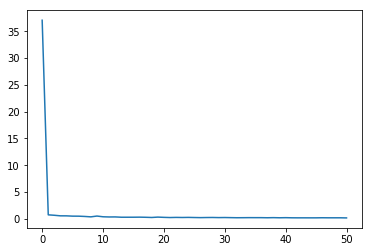

In [0]:
if training:
  plt.plot(loss_history)

  np.save("epoch_loss.npy", loss_history)
  print(type(loss_history))

## Verification

In [0]:
# could load data here directly
model = torch.load('model.pytorch')
model.eval()

Model(
  (Encoder): Encoder(
    (Q): Sequential(
      (0): Linear(in_features=2118, out_features=512, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.5, inplace=False)
      (3): Linear(in_features=512, out_features=512, bias=True)
      (4): ReLU()
    )
    (getMu): Linear(in_features=512, out_features=3, bias=True)
    (getLogvar): Linear(in_features=512, out_features=3, bias=True)
  )
  (Decoder): Decoder(
    (P): Sequential(
      (0): Linear(in_features=2115, out_features=512, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.5, inplace=False)
      (3): Linear(in_features=512, out_features=512, bias=True)
      (4): ReLU()
      (5): Linear(in_features=512, out_features=6, bias=True)
    )
  )
)

2269
4.0


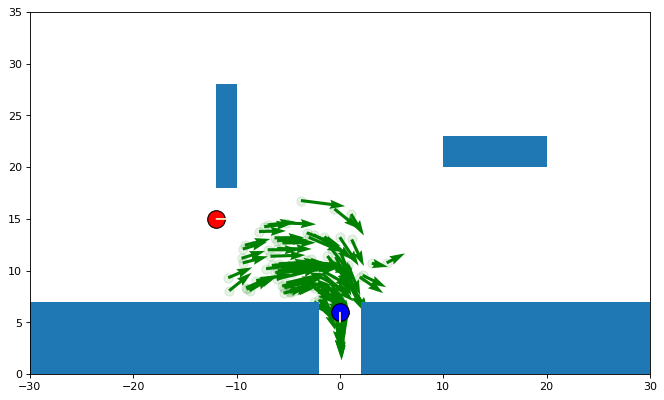

In [0]:
# plot the latent space
num_viz = 100 # 3000
c_gapsInitGoal = c_test

vizIdx = randint(0,numTest-1);
print(vizIdx)
# vizIdx = 31401
c_sample_seed = c_test[vizIdx,:-1]
c_sample = np.repeat([c_sample_seed],num_viz,axis=0)
c_viz = c_gapsInitGoal[vizIdx,:]

# directly sample from the latent space (preferred, what we will use in the end)
z = torch.Tensor(np.random.randn(num_viz, 3)).cuda()
c_sample = torch.Tensor(c_sample).cuda()
input_P = torch.cat((z,c_sample), 1)
y_viz = model.Decoder(input_P)
y_viz = y_viz.data.cpu().numpy()

fig1 = plt.figure(figsize=(10,6), dpi=80)
plt.xlim(-30, 30)
plt.ylim(0, 35)

plt.scatter(y_viz[:,0],y_viz[:,1], color="green", s=70, alpha=0.1)
Q = plt.quiver(y_viz[0:100,0],y_viz[0:100,1],y_viz[0:100,3],y_viz[0:100,4],width=0.005,color="g")


print(c_viz[-1])
ax = plt.gca()
rects = []
if c_viz[-1] == 1.:
    rects.append(patches.Rectangle([-30,0], 20, 3, angle=0.0))
    rects.append(patches.Rectangle([10,0], 20, 3, angle=0.0))
if c_viz[-1] == 2.:    
    rects.append(patches.Rectangle([-30,0], 20, 3, angle=0.0))
    rects.append(patches.Rectangle([10,0], 20, 3, angle=0.0))
if c_viz[-1] == 3.:    
    rects.append(patches.Rectangle([-30,0], 28, 7, angle=0.0))
    rects.append(patches.Rectangle([2,0], 28, 7, angle=0.0))
if c_viz[-1] == 4.:
    rects.append(patches.Rectangle([-30,0], 28, 7, angle=0.0))
    rects.append(patches.Rectangle([2,0], 28, 7, angle=0.0))
    rects.append(patches.Rectangle([-12,18], 2, 10, angle=0.0))
    rects.append(patches.Rectangle([10, 20], 10, 3, angle=0.0))
if c_viz[-1] == 5.:
    rects.append(patches.Rectangle([-30,0], 28, 7, angle=0.0))
    rects.append(patches.Rectangle([2,0], 28, 7, angle=0.0))
    rects.append(patches.Rectangle([-20,18], 10, 2, angle=0.0))
    rects.append(patches.Rectangle([5, 23], 5, 5, angle=0.0))
    rects.append(patches.Rectangle([15, 12], 10, 3, angle=0.0))
for i in range(len(rects)):
  ax.add_patch(rects[i])

init = c_viz[0:6]
goal = c_viz[6:12]


plt.scatter(init[0], init[1], color="red", s=250, edgecolors='black') # init
plt.scatter(goal[0], goal[1], color="blue", s=250, edgecolors='black') # goal
plt.arrow(init[0], init[1], init[3], init[4], color = "wheat", shape="right")
plt.arrow(goal[0], goal[1], goal[3], goal[4], color = "wheat", shape="right")

plt.show()

# plt.figure(figsize=(10,6), dpi=80)
# viz1 = 1;
# viz2 = 4;
# plt.scatter(y_viz[:,viz1],y_viz[:,viz2], color="green", s=70, alpha=0.1)
# plt.scatter(c_viz[viz1+9],c_viz[viz2+9], color="red", s=250, edgecolors='black') # init
# plt.scatter(c_viz[viz1+9+dim],c_viz[viz2+9+dim], color="blue", s=500, edgecolors='black') # goal
# plt.show()